# Probabilistic Programming

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import daft
from IPython.display import Image
import pystan
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter("ignore",category=FutureWarning)

In [3]:
from scipy.optimize import minimize

## Domain specific languages (DSL)

A simplified computer language for working in a specific domain. Some examples of DSLs that you are already familiar with include

- regular expressions for working with text
- SQL for working with relational databases
- LaTeX for typesetting documents

Probabilistic programming languages are DSLs for dealing with models involving random variables and uncertainty. We will introduce the `Stan` probabilistic programming languages in this notebook.

### Stan and PyStan references

- [Paper describing Stan](http://www.stat.columbia.edu/~gelman/research/unpublished/stan-resubmit-JSS1293.pdf)
- [Stan documentation](http://mc-stan.org/users/documentation/index.html)
- [Stan examples](https://github.com/stan-dev/example-models/wiki)
- [PyStan docs](http://pystan.readthedocs.org/en/latest/)
- [PyStan GitHub page](https://github.com/stan-dev/pystan)

### Other packages for probabilistic programming

There several alternative packages for probabilistic programming in Python. You might like to explore them by recreating the PyStan examples shown in this notebooks using the following:

- [PyMC3](https://github.com/pymc-devs/pymc3)
- [Edward](http://edwardlib.org)
- [ZhuSuan](https://github.com/thu-ml/zhusuan)

## Examples

In  general, the problem is set up like this:
    
- We have some observed outcomes $y$ that we want to model
- The model is formulated as a probability distribution with some parameters $\theta$ to be estimated 
- We want to estimate the posterior distribution of the model parameters given the data
$$
P(\theta \mid y) = \frac{P(y \mid \theta) \, P(\theta)}{\int P(y \mid \theta^*) \, P(\theta^*) \, d\theta^*}
$$
- For formulating a specification using probabilistic programming, it is often useful to think of how we would simulated a draw from the model

### Coin bias

We toss a coin $n$ times, observed the number of times $y$ it comes up heads, and want to estimate the expected proportion of times $\theta$ that it comes up heads. An appropriate likelihood is the binomial, and it is convenient to use the $\beta$ distribution as the prior. In this case, the posterior is also a beta distribution, and there is a simple closed form formula: if the prior is $\beta(a, b)$ and we observe $y$ heads and $n-y$ tails in $n$ tosses, then the posterior is $\beta(a+y, a+(n-y)$. 

#### Graphical model

In [4]:
pgm = daft.PGM(shape=[2.5, 3.0], origin=[0, -0.5])

pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2, fixed=True))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2, fixed=True))
pgm.add_node(daft.Node("p", r"$p$", 1, 1))
pgm.add_node(daft.Node("n", r"$n$", 2, 0, fixed=True))
pgm.add_node(daft.Node("y", r"$y$", 1, 0, observed=True))

pgm.add_edge("alpha", "p")
pgm.add_edge("beta", "p")
pgm.add_edge("n", "y")
pgm.add_edge("p", "y")

pgm.render()
plt.close()
pgm.figure.savefig("bias.png", dpi=300)
pass

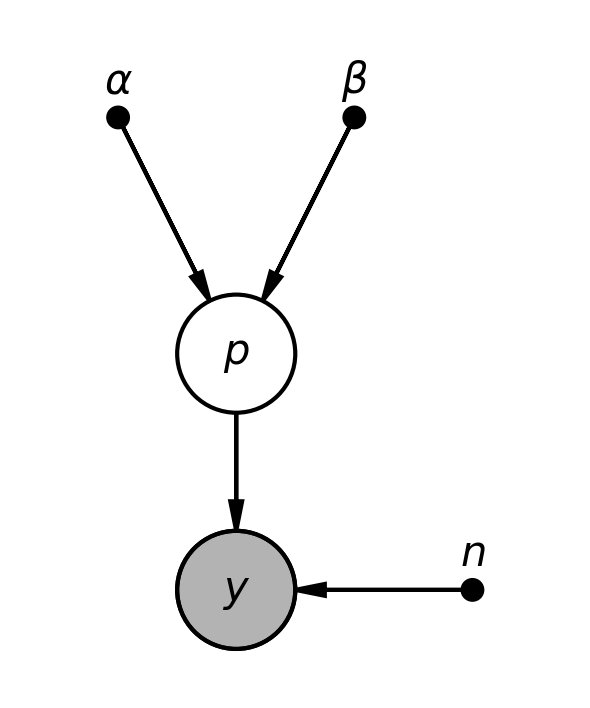

In [5]:
Image("bias.png", width=400)

#### Analytical solution

Illustrating what $y$, $\theta$, posterior, likelihood, prior, MLE and MAP refer to.

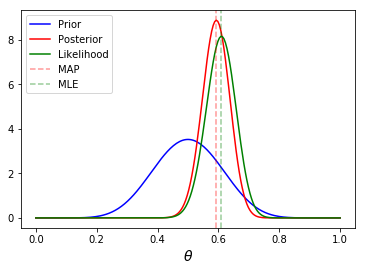

In [6]:
n = 100
h = 61
p = h/n
rv = stats.binom(n, p)
mu = rv.mean()

a, b = 10, 10
prior = stats.beta(a, b)
post = stats.beta(h+a, n-h+b)
ci = post.interval(0.95)

thetas = np.linspace(0, 1, 200)
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, n*stats.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlabel(r'$\theta$', fontsize=14)
plt.legend(loc='upper left')
plt.show()
pass

## Using `stan`

### Coin bias

#### Data

In [7]:
data = {
    'n': 100,
    'y': 61,
}

#### Model

In [8]:
code = """
data {
    int<lower=0> n; // number of tosses
    int<lower=0> y; // number of heads
}
transformed data {}
parameters {
    real<lower=0, upper=1> p;
}
transformed parameters {}
model {
    p ~ beta(2, 2);
    y ~ binomial(n, p);
}
generated quantities {}
"""

#### Compile the C++ model

In [9]:
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7f1947cd2d39ae427cd7b6bb6e6ffd77 NOW.


In [10]:
print(sm.model_cppcode)

// Code generated by Stan version 2.17.1

#include <stan/model/model_header.hpp>

namespace anon_model_7f1947cd2d39ae427cd7b6bb6e6ffd77_namespace {

using std::istream;
using std::string;
using std::stringstream;
using std::vector;
using stan::io::dump;
using stan::math::lgamma;
using stan::model::prob_grad;
using namespace stan::math;

static int current_statement_begin__;

stan::io::program_reader prog_reader__() {
    stan::io::program_reader reader;
    reader.add_event(0, 0, "start", "unknown file name");
    reader.add_event(15, 15, "end", "unknown file name");
    return reader;
}

class anon_model_7f1947cd2d39ae427cd7b6bb6e6ffd77 : public prob_grad {
private:
    int n;
    int y;
public:
    anon_model_7f1947cd2d39ae427cd7b6bb6e6ffd77(stan::io::var_context& context__,
        std::ostream* pstream__ = 0)
        : prob_grad(0) {
        ctor_body(context__, 0, pstream__);
    }

    anon_model_7f1947cd2d39ae427cd7b6bb6e6ffd77(stan::io::var_context& context__,
        unsigned 

#### MAP

In [11]:
fit_map = sm.optimizing(data=data)

In [12]:
fit_map.keys()

odict_keys(['p'])

In [13]:
fit_map.get('p')

array(0.60784305)

In [14]:
fit = sm.sampling(data=data, iter=1000, chains=4)

Summarizing the MCMC fit

In [15]:
print(fit.stansummary())

Inference for Stan model: anon_model_7f1947cd2d39ae427cd7b6bb6e6ffd77.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.61  1.6e-3   0.05   0.51   0.57   0.61   0.64    0.7    865    1.0
lp__ -70.25    0.03   0.71 -72.29 -70.42 -69.97  -69.8 -69.74    728    1.0

Samples were drawn using NUTS at Wed Mar 21 09:57:17 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Interpreting `n_eff` and `Rhat`

#### Effective sample size

$$
\hat{n}_{eff} = \frac{mn}{1 + 2 \sum_{t=1}^T \hat{\rho}_t}
$$

where $m$ is the number of chains, $n$ the number of steps per chain, $T$ the time when the autocorrelation first becomes negative, and $\hat{\rho}_t$ the autocorrelation at lag $t$.

##### Gelman-Rubin $\widehat{R}$

$$
\widehat{R} = \frac{\widehat{V}}{W}
$$

where $W$ is the within-chain variance and $\widehat{V}$ is the posterior variance estimate for the pooled traces.  Values greater than one indicate that one or more chains have not yet converged.

Discrad burn-in steps for each chain. The idea is to see if the starting values of each chain come from the same distribution as the stationary state. 

- $W$ is the number of chains $m \times$ the variacne of each individual chain
- $B$ is the number of steps $n \times$ the variance of the chain means
- $\widehat{V}$ is the weigthed average $(1 - \frac{1}{n})W + \frac{1}{n}B$

The idea is that $\widehat{V}$ is an unbiased estimator of $W$ if the starting values of each chain come from the same distribution as the stationary state. Hence if $\widehat{R}$ differs significantly from 1, there is probably no convergence and we need more iterations. This is done for each parameter $\theta$.

#### $\widehat{R}$ is a measure of chain convergence

In [16]:
ps = fit.extract(None, permuted=False)

In [17]:
fit.model_pars

['p']

In [18]:
ps.shape

(500, 4, 2)

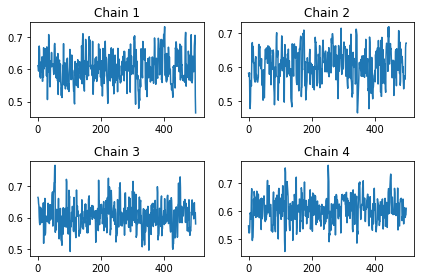

In [19]:
fig, axes = plt.subplots(2,2)
for i, ax in enumerate(axes.ravel()):
    ax.plot(ps[:, i, 0])
    ax.set_title('Chain %d' % (i+1))
plt.tight_layout()

#### Plotting

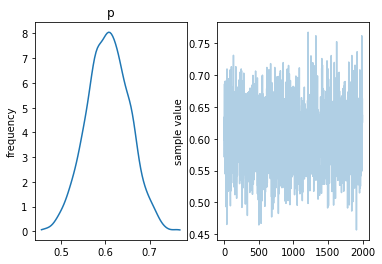

In [20]:
fit.plot()
pass

#### Extracting parameters

In [21]:
params = fit.extract()

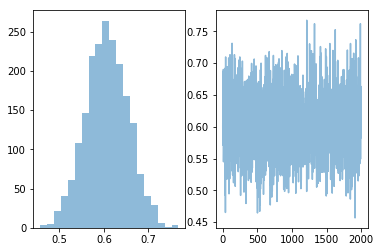

In [22]:
p = params['p']
plt.subplot(121)
plt.hist(p, 20, alpha=0.5)
plt.subplot(122)
plt.plot(p, alpha=0.5)
pass

### Coin toss as Bernoulli model

In [23]:
%%file bernoulli_model.stan

data { 
  int<lower=0> N; 
  int<lower=0,upper=1> y[N];
} 

parameters {
  real<lower=0,upper=1> theta;
} 

model {
  theta ~ beta(1,1);
  for (n in 1:N) 
    y[n] ~ bernoulli(theta);
}

Overwriting bernoulli_model.stan


In [24]:
y = np.random.choice([0,1], 100, p=[0.6, 0.4])
data = {
    'N': len(y),
    'y': y
}

In [25]:
sm = pystan.StanModel('bernoulli_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb711f588d2bebfe1cfbb8d68ae0845e NOW.


In [26]:
fit = sm.sampling(data=data, iter=1000, chains=4)

In [27]:
fit

Inference for Stan model: anon_model_fb711f588d2bebfe1cfbb8d68ae0845e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.33  1.7e-3   0.05   0.24    0.3   0.33   0.36   0.43    756   1.01
lp__  -65.46    0.03    0.8 -67.62 -65.65 -65.17 -64.98 -64.92    956    1.0

Samples were drawn using NUTS at Wed Mar 21 09:58:26 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

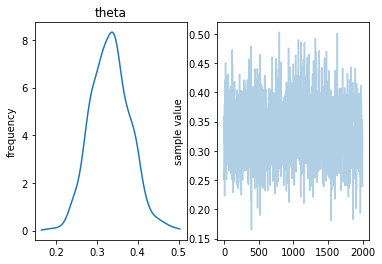

In [28]:
fit.plot()
pass

#### MAP

In [29]:
opt = sm.optimizing(data)

In [30]:
opt

OrderedDict([('theta', array(0.33000006))])

The MAP maximizes the log probability of the model.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


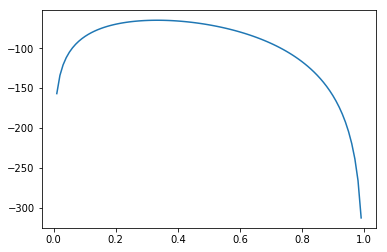

In [31]:
xi = np.linspace(0, 1, 100)
plt.plot(xi, [fit.log_prob(np.log(x) - np.log(1-x)) for x in xi])
pass

Stan automatically transforms variables so as to work with unconstrained optimization. Knowing this, we can try to replicate the optimization procedure.

In [32]:
p0 = 0.1
x0 = np.log(p0) - np.log(1 - p0)
sol = minimize(fun=lambda x: -fit.log_prob(x), x0=x0)

In [33]:
sol

      fun: 64.92444516607115
 hess_inv: array([[0.04413613]])
      jac: array([-5.7220459e-06])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([-0.69314706])

In [34]:
np.exp(sol.x)/(1 + np.exp(sol.x))

array([0.33333336])

### Linear regression

Another simple example of a probabilistic model is linear regression

$$
y = ax + b + \epsilon
$$

with $\epsilon \sim N(0, \sigma^2)$.

We can think of the simulation model as sampling $y$ from the probability distribution 

$$
y \sim N(ax + b, \sigma^2)
$$

and the parameter $\theta = (a, b, \sigma)$ is to be estimated (as posterior probability, MLE or MAP). To complete the model, we need to specify prior distributions for $a$, $b$ and $\sigma$. For example, if the observations $y$ are standardized to have zero mean and unit standard distribution, we can use

$$
a \sim N(0, 10) \\
b \sim N(0, 10) \\
\sigma \sim \vert{N(0, 1)}
$$

To get a more robust fit that is less sensitive to outliers, we can use a student-T distribution for $y$

$$
y \sim t(ax + b, \sigma^2, \nu)
$$

with an extra parameter $\nu$ for the degrees of freedom for which we also need to specify a prior.

In [35]:
# Instantiate the PGM.
pgm = daft.PGM(shape=[4.0, 3.0], origin=[-0.3, -0.7])

# Hierarchical parameters.
pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2))
pgm.add_node(daft.Node("sigma", r"$\sigma$", 0, 0))

# Deterministic variable.
pgm.add_node(daft.Node("mu", r"$\mu_n$", 1, 1))

# Data.
pgm.add_node(daft.Node("x", r"$x_n$", 2, 1, observed=True))
pgm.add_node(daft.Node("y", r"$y_n$", 1, 0, observed=True))

# Add in the edges.
pgm.add_edge("alpha", "mu")
pgm.add_edge("beta", "mu")
pgm.add_edge("x", "mu")
pgm.add_edge("mu", "y")
pgm.add_edge("sigma", "y")

# And a plate.
pgm.add_plate(daft.Plate([0.5, -0.5, 2, 2], label=r"$n = 1, \cdots, N$",
    shift=-0.1, rect_params={'color': 'white'}))

# Render and save.
pgm.render()
plt.close()
pgm.figure.savefig("lm.png", dpi=300)

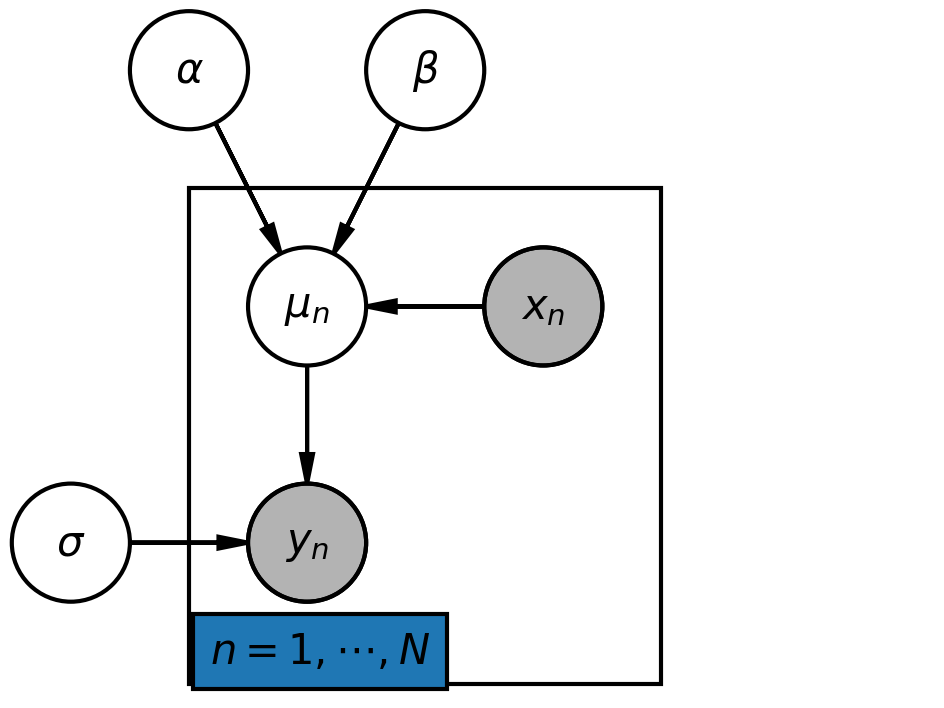

In [36]:
Image(filename="lm.png", width=400)

### Linear model

In [38]:
%%file linear.stan

data {
    int<lower=0> N;
    real x[N];
    real y[N];
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma; // half-normal distribution
}

transformed parameters {
    real mu[N];
    for (i in 1:N) {
        mu[i] = alpha + beta*x[i];
    }
}

model {
    alpha ~ normal(0, 10);
    beta ~ normal(0, 1);
    sigma ~ normal(0, 1);
    y ~ normal(mu, sigma);
}

Overwriting linear.stan


In [39]:
n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a + _b*x + np.random.randn(n)

data = {
    'N': n,
    'x': x,
    'y': y
}

#### Saving and reloading compiled models

Since Stan models take a while to compile, we will define two convenience functions to save and load them. For example, this will allow reuse of the mode in a different session or notebook without recompilation.

In [40]:
import pickle

def save(filename, x):
    with open(filename, 'wb') as f:
        pickle.dump(x, f, protocol=pickle.HIGHEST_PROTOCOL)
        
def load(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [41]:
model_name = 'linear'
filename = '%s.pkl' % model_name
if not os.path.exists(filename):
    sm = pystan.StanModel('%s.stan' % model_name)
    save(filename, sm)
else:
    sm = load(filename)

We can inspect the original model from the loaded compiled version.

In [42]:
print(sm.model_code)


data {
    int<lower=0> N;
    real x[N];
    real y[N];
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

transformed parameters {
    real mu[N];
    for (i in 1:N) {
        mu[i] = alpha*x[i] + beta;
    }
}

model {
    alpha ~ normal(0, 10);
    beta ~ normal(0, 1);
    sigma ~ normal(0, 1);
    y ~ normal(mu, sigma);
}


In [43]:
fit = sm.sampling(data)

In [44]:
fit

Inference for Stan model: anon_model_3e02a2e67db7786f6ac294d214bdf9b6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    6.33    0.06   1.79    3.2   5.03    6.2   7.51   10.1    945    1.0
beta     3.21    0.04   1.06   1.05   2.47   3.24   3.99   5.15    868    1.0
sigma    1.82    0.02   0.49   0.99   1.46   1.77   2.14   2.85   1027    1.0
mu[0]    3.21    0.04   1.06   1.05   2.47   3.24   3.99   5.15    868    1.0
mu[1]    3.84    0.03   0.92   1.97   3.21   3.87   4.51   5.53    905    1.0
mu[2]    4.48    0.03   0.79   2.87   3.94    4.5   5.05   5.91    987    1.0
mu[3]    5.11    0.02   0.68   3.71   4.66   5.13    5.6   6.33   1174    1.0
mu[4]    5.74    0.02   0.61   4.44   5.35   5.78   6.18   6.79   1633    1.0
mu[5]    6.37    0.01   0.58    5.1   6.01   6.42   6.78   7.36   2613    1.0
mu[6]    7.01  9.6e-3   0.61   

#### Re-using the model on a new data set

In [45]:
n = 121
_a = 2
_b = 1
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

data = {
    'N': n,
    'x': x,
    'y': y
}

In [46]:
fit2 = sm.sampling(data)

In [47]:
print(fit2.stansummary(pars=['alpha', 'beta', 'sigma']))

Inference for Stan model: anon_model_3e02a2e67db7786f6ac294d214bdf9b6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   1.18  7.7e-3    0.3   0.59   0.98   1.18   1.38   1.77   1501    1.0
beta    1.29  4.2e-3   0.17   0.96   1.17   1.29   1.41   1.63   1661    1.0
sigma   0.98  1.4e-3   0.06   0.87   0.94   0.98   1.02    1.1   1870    1.0

Samples were drawn using NUTS at Wed Mar 21 09:58:28 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Hierarchical models

Gelman's book has an example where the dose of a drug may be affected to the number of rat deaths in an experiment.

| Dose (log g/ml) | # Rats | # Deaths |
|-----------------|--------|----------|
| -0.896          | 5      | 0        |
| -0.296          | 5      | 1        |
| -0.053          | 5      | 3        |
| 0.727           | 5      | 5        |

We will model the number of deaths as a random sample from a binomial distribution, where $n$ is the number of rats and $p$ the probability of a rat dying. We are given $n = 5$, but we believe that $p$ may be related to the drug dose $x$. As $x$ increases the number of rats dying seems to increase, and since $p$ is a probability, we use the following model:

$$
y \sim \text{Bin}(n, p) \\
\text{logit}(p) = \alpha + \beta x \\
\alpha \sim \mathcal{N}(0, 5) \\
\beta \sim \mathcal{N}(0, 10)
$$

where we set vague priors for $\alpha$ and $\beta$, the parameters for the logistic model.

**Exercise**: Create the plate diagram for this model using `daft`.

### Hierarchical model in Stan

In [48]:
data = dict(
    N = 4,
    x = [-0.896, -0.296, -0.053, 0.727],
    y = [0, 1, 3, 5],
    n = [5, 5, 5, 5],
)

In [49]:
%%file dose.stan

data {
    int<lower=0> N;
    int<lower=0> n[N];
    real x[N];
    int<lower=0> y[N];
}

parameters {
    real alpha;
    real beta;
}

transformed parameters {
    real <lower=0, upper=1> p[N];
    for (i in 1:N) {
        p[i] = inv_logit(alpha + beta*x[i]);
    }
}

model {
    alpha ~ normal(0, 5);
    beta ~ normal(0, 10);
    for (i in 1:N) {
        y ~ binomial(n, p);
    }
}

Overwriting dose.stan


In [50]:
model_name = 'dose'
filename = '%s.pkl' % model_name
if not os.path.exists(filename):
    sm = pystan.StanModel('%s.stan' % model_name)
    save(filename, sm)
else:
    sm = load(filename)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_40004ac135c74450331b836ef8235826 NOW.


In [51]:
fit = sm.sampling(data=data)
fit

Inference for Stan model: anon_model_40004ac135c74450331b836ef8235826.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.91    0.02   0.51  -0.01   0.56    0.9   1.25    2.0   1082    1.0
beta    8.29    0.07   2.32   4.49   6.58   8.04   9.76  13.32   1053    1.0
p[0]  4.6e-3  1.8e-4 7.6e-3 2.9e-5 4.9e-4 1.8e-3 5.4e-3   0.03   1889    1.0
p[1]    0.19  1.3e-3   0.07   0.07   0.14   0.18   0.23   0.34   3090    1.0
p[2]    0.61  2.8e-3    0.1   0.42   0.54   0.61   0.68    0.8   1290    1.0
p[3]     1.0  2.6e-4 9.5e-3   0.97    1.0    1.0    1.0    1.0   1321    1.0
lp__  -24.89    0.03    1.0 -27.51 -25.31 -24.59 -24.16 -23.88   1251    1.0

Samples were drawn using NUTS at Wed Mar 21 09:59:36 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

In [52]:
alpha, beta, *probs = fit.get_posterior_mean()
a = alpha.mean()
b = beta.mean()

#### Logistic function

$$
f(x) = \frac{e^z}{1 + e^z}
$$

In [53]:
def logistic(a, b, x):
    """Logistic function."""
    return np.exp(a + b*x)/(1 + np.exp(a + b*x))

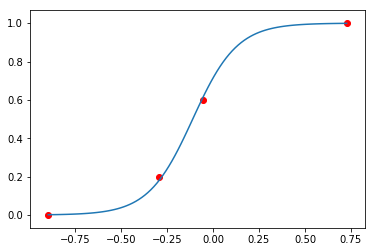

In [54]:
xi =  np.linspace(min(data['x']), max(data['x']), 100)
plt.plot(xi, logistic(a, b, xi))
plt.scatter(data['x'], [y_/n_ for (y_, n_) in zip(data['y'], data['n'])], c='red')
pass

#### Sampling from prior

In [55]:
%%file dose_prior.stan

data {
    int<lower=0> N;
    int<lower=0> n[N];
    real x[N];
}

parameters {
    real alpha;
    real beta;
}

transformed parameters {
    real <lower=0, upper=1> p[N];
    for (i in 1:N) {
        p[i] = inv_logit(alpha + beta*x[i]);
    }
}

model {
    alpha ~ normal(0, 5);
    beta ~ normal(0, 10);
}

Overwriting dose_prior.stan


In [56]:
sm = pystan.StanModel('dose_prior.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19656edfaafe00f17bef18a5ebf7150a NOW.


In [57]:
fit_prior = sm.sampling(data=data)

In [58]:
alpha, beta, *probs, lp = fit_prior.get_posterior_mean()
a = alpha.mean()
b = beta.mean()
p = [prob.mean() for prob in probs]

In [59]:
p

[0.49204373896207554,
 0.5049607712489612,
 0.5091310988390625,
 0.5087831209942868]

In [60]:
y = np.random.binomial(5, p)

In [61]:
y

array([3, 3, 2, 3])

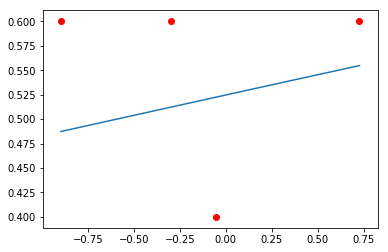

In [62]:
xi =  np.linspace(min(data['x']), max(data['x']), 100)
plt.plot(xi, logistic(a, b, xi))
plt.scatter(data['x'], [y_/n_ for (y_, n_) in zip(y, data['n'])], c='red')
pass

#### Sampling from posterior

In [63]:
%%file dose_post.stan

data {
    int<lower=0> N;
    int<lower=0> n[N];
    real x[N];
    int<lower=0> y[N];
}

parameters {
    real alpha;
    real beta;
}

transformed parameters {
    real <lower=0, upper=1> p[N];
    for (i in 1:N) {
        p[i] = inv_logit(alpha + beta*x[i]);
    }
}

model {
    alpha ~ normal(0, 5);
    beta ~ normal(0, 10);
    for (i in 1:N) {
        y ~ binomial(n, p);
    }
}

generated quantities {
    int<lower=0> yp[N];
    for (i in 1:N) {
        yp[i] = binomial_rng(n[i], p[i]);
    }
}

Overwriting dose_post.stan


In [64]:
sm = pystan.StanModel('dose_post.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc9e5eb156c324b98343f4bde238f913 NOW.


In [65]:
fit_post = sm.sampling(data=data)

In [66]:
yp = fit_post.extract('yp')['yp']

In [67]:
yp.shape

(4000, 4)

In [68]:
np.c_[data['x'], yp.T[:, :6]]

array([[-0.896,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.296,  0.   ,  3.   ,  1.   ,  1.   ,  2.   ,  2.   ],
       [-0.053,  3.   ,  5.   ,  1.   ,  3.   ,  4.   ,  4.   ],
       [ 0.727,  5.   ,  5.   ,  5.   ,  5.   ,  5.   ,  5.   ]])